<h1 align="center">Natural Language Processing From Scratch</h1>
<h2 align="center">Bruno Gonçalves</h2>
<h4 align="center">bgoncalves@gmail.com</h4>
<h4 align="center">@bgoncalves</h4>

# Lesson IV - Applications

In [1]:
import string
import gzip
from collections import Counter
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import normalize

%matplotlib inline

# word2vec embeddings

We start by loading a well trained set of word embeddings from project polyglot: https://sites.google.com/site/rmyeid/projects/polyglot


In [7]:
word_list, embeddings = pd.read_pickle('data/polyglot-en.pkl')
embeddings = normalize(embeddings)
word_list = np.array(word_list)
word_dict = dict(zip(word_list, range(embeddings.shape[0])))
print(embeddings.shape)

(100004, 64)


# Find the most similar words

In [11]:
def most_similar(word, embeddings, dictionary, reverse_dictionary, top_k=8):   
    valid_word = dictionary[word]
    similarity = cosine_similarity(embeddings, embeddings[valid_word, :].reshape(1, -1))
    nearest = (-similarity).argsort(axis=0)[1:top_k + 1].flatten()
    return reverse_dictionary[nearest]

In [12]:
most_similar("king", embeddings, word_dict, word_list)

array(['queen', 'prince', 'princess', 'emperor', 'King', 'ruler',
       'father', 'hero'], dtype='<U128')

# Analogies

Question task set downloaded from: http://download.tensorflow.org/data/questions-words.txt

In [13]:
questions = pd.read_table('data/questions-words.txt', comment=':', sep=' ', header=None)
print(questions.shape)

(19544, 4)


Let us now define a function to automatically evaluate this specific type of analogy. We simply look up the embeddings for each of the four words in the question and perform the necessary vector algebra. To be safe, we enclose the entire function into a try/except block to catch the exceptions thrown when we try to use a word that is not part of our vocabulary (included in the embeddings)

In [21]:
def evaluate_analogy(question):
    try:
        word1, word2, word3, word4 = question
        key1 = word_dict[word1]
        key2 = word_dict[word2]
        key3 = word_dict[word3]
        key4 = word_dict[word4]

        vec1 = embeddings[key1, :]
        vec2 = embeddings[key2, :]
        vec3 = embeddings[key3, :]
        vec4 = embeddings[key4, :]

        predict = vec2-vec1+vec3

        sim = np.matmul(predict, embeddings.T)
        nearest = np.argsort(-sim)[:4]

        return word4.lower() in word_list[nearest]
    except Exception as e:
        pass

In [24]:
results = [evaluate_analogy(questions.iloc[i]) for i in range(questions.shape[0])]

In [25]:
clean_results = [res for res in results if res is not None]
accuracy = np.mean(clean_results)
print(accuracy)

0.17619910993901433


We this simple approach we achieve ~35% accuracy. Our results are penalized by the fact that our embeddings weren't generated specifically for this purpose and are missing many of the words used in the analogies.

# Visualization

Text(0,0.5,'embeddings dimensions')

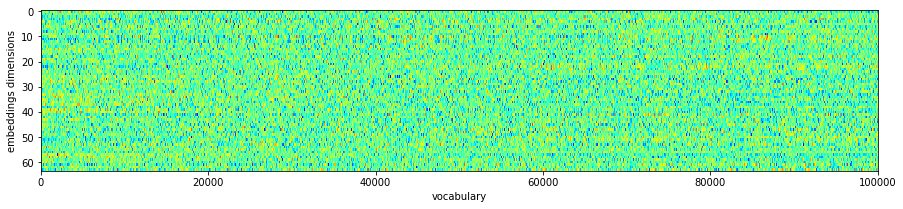

In [26]:
plt.figure(figsize=(15, 5))
plt.imshow(embeddings.T, aspect=300, cmap=cm.jet)
plt.xlabel("vocabulary")
plt.ylabel("embeddings dimensions")

# Visualizing the embedding space

Using a dimensionality reduction algorithm like t-SNE we are able to project our word embeddings into a two dimensional space for visualization purposes. While the details of how t-SNE does its magic are beyond the scope of this course, the fundamental idea is the same of algorithms like PCA or the matrix decomposition methods we explored. Project the dataset into a latent, and lower dimensional, space in a smart way. t-SNE became popular in recent year due to its hability to make projections into 2D space in a way that preserves as much of the higher dimensional structure as possible resulting in beautiful and useful visualizations. 

The start implementation of t-SNE is that that comes bundled with **sklearn**. Here we simply call it to generate the plot we saw in the slides.

In [34]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
plot_only = 500 # Plot only 500 words
low_dim_embs = tsne.fit_transform(np.array(embeddings)[:plot_only, :])
labels = [reverse_dictionary[i] for i in range(plot_only)]

plt.figure(figsize=(18, 18))  # in inches
for i, label in enumerate(labels):
    x, y = low_dim_embs[i, :]
    plt.scatter(x, y)
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')

plt.show()

NameError: name 'reverse_dictionary' is not defined

# Language Detection

We start by building a vector of character distributions for each language. Due to the total size of the google books dataset, we include only a partial file in the data directory. The interested student is encouraged to download all teh files and use the code below to build hers or his own language detector.

In [28]:
characters = sorted(set(string.ascii_letters.lower()))

dict_char = dict(zip(characters, range(len(characters))))
counts = np.zeros(len(characters), dtype='uint64')

line_count = 0

filename = "data/googlebooks-eng-all-1gram-20120701-a.gz"

for line in gzip.open(filename, "rt"):
    fields = line.lower().strip().split()

    line_count += 1

    if line_count % 100000 == 0:
        print(filename, line_count)
        break

    count = int(fields[2])
    word = fields[0]

    if "_" in word:
        continue

    letters = [char for char in word if char in characters]

    if len(letters) != len(word):
        continue

    for letter in letters:
        if letter not in dict_char:
            continue

        counts[dict_char[letter]] += count

total = np.sum(counts)
list_char = list(dict_char.items())
list_char.sort(key=lambda x: x[1])

for key, value in enumerate(list_char):
    print(value[0], counts[key]/total)


data/googlebooks-eng-all-1gram-20120701-a.gz 100000
a 0.28373493701257363
b 0.001087943998322763
c 0.019432018645918737
d 0.002248125464286325
e 0.024034285610183632
f 0.0017618837696721584
g 0.003034393192545418
h 0.008572819698087103
i 0.038752026329494094
j 2.9965309886103013e-05
k 0.0005496779013550016
l 0.025656663800569617
m 0.006491675783290543
n 0.025316248929828675
o 0.02943861409080565
p 0.000783256279879127
q 0.001046790644919758
r 0.2529855970069149
s 0.010861035651642327
t 0.24907055561567576
u 0.002351195315185786
v 0.011610737124340345
w 0.0003748367512946128
x 4.5740451244935094e-05
y 0.0006793846191942876
z 4.9591002888668925e-05


Not surprisingly, the most common character is the letter *a*. This is an artifact of the fact that we are using the datafile containing only words that start with the letter *a*. If you were to run it on the entire dataset, the resutls shown in the slides would be found. 

For simplicity, I've also included the complete table for all 5 languages in the repository. This is the datset that we will used to build our language detector.

# Visualization

Let's start by making a quick visualization of the probabiltity distributions for each language. THe first step is to load up the language character frequency from the file:

Text(0,0.5,'P(letter)')

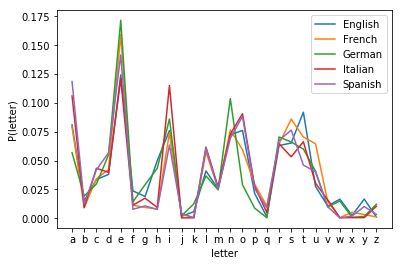

In [29]:
P_letter_lang = pd.read_csv('data/table_langs.dat', sep=' ', header=0, index_col = 0)

plt.plot(range(26), pd.np.array(P_letter_lang["eng"]), '-')
plt.plot(range(26), pd.np.array(P_letter_lang["fre"]), '-')
plt.plot(range(26), pd.np.array(P_letter_lang["ger"]), '-')
plt.plot(range(26), pd.np.array(P_letter_lang["ita"]), '-')
plt.plot(range(26), pd.np.array(P_letter_lang["spa"]), '-')
plt.xticks(list(range(26)), P_letter_lang.index)
plt.legend(["English", "French", "German", "Italian", "Spanish"])
plt.xlabel("letter")
plt.ylabel("P(letter)")

As we can see, there definitely some common trends (the letters *q* and *j* are underrepreented across all languages), there are also some significant peaks that will help us discriminate between one language and the next.

## The detector

Based on this table of data it is extremely simple to build a Naive Bayes classifier. To do so, one must just calculte the correct set of log likelihoods so that we may use them later on.

In [30]:
def process_data(P_letter_lang):
    langs = list(P_letter_lang.columns)

    P_letter = P_letter_lang.mean(axis=1)
    P_letter /= P_letter.sum()

    P_lang_letter = np.array(P_letter_lang)/(P_letter_lang.shape[1]*P_letter.T[:,None])

    L_lang_letter = np.log(P_lang_letter.T)

    return langs, P_letter, L_lang_letter

In [31]:
langs, P_letter, L_lang_letter = process_data(P_letter_lang)

Finally, we have all the tools we need to write down our mini detector:

In [32]:
def detect_lang(langs, P_letter, L_lang_letter, text):
    counts = np.zeros(26, dtype='int')
    pos = dict(zip(P_letter.index, range(26)))

    text_counts =  Counter(text).items()

    for letter, count in text_counts:
        if letter in pos:
            counts[pos[letter]] += count

    L_text = np.dot(L_lang_letter, counts)
    index = np.argmax(L_text)
    lang_text = langs[index]
    prob = np.exp(L_text[index])/np.sum(np.exp(L_text))*100

    return lang_text, prob, L_text

And that's all there is to it. So now let's test our detector with a few past headlines from Google News:

In [33]:
texts = {}
texts["eng"] = "North Korea’s Test of Nuclear Bomb Amplifies a Global Crisis".lower()
texts["ita"] = "Nucleare, Onu riunisce consiglio sicurezza. E Seul simula attacco alle basi di Kim".lower()
texts["fre"] = "Corée du Nord : les Etats-Unis prêts à utiliser leurs capacités nucléaires".lower()
texts["spa"] = "Estados Unidos amenaza con una “respuesta militar masiva” a Corea del Norte".lower()
texts["ger"] = "Überraschung".lower()
texts["ita2"] = "Wales lancia la Wikipedia delle news. Contro il fake in campo anche Google".lower()

for lang in texts:
    text = texts[lang]
    lang_text, prob, L_text = detect_lang(langs, P_letter, L_lang_letter, text)
    print(lang, lang_text, prob, text)


ger ger 70.51752677149888 überraschung
eng eng 91.87493065763115 north korea’s test of nuclear bomb amplifies a global crisis
ita2 eng 97.44427974112531 wales lancia la wikipedia delle news. contro il fake in campo anche google
spa spa 58.42864800691954 estados unidos amenaza con una “respuesta militar masiva” a corea del norte
fre fre 94.90751389582378 corée du nord : les etats-unis prêts à utiliser leurs capacités nucléaires
ita ita 94.20224266512197 nucleare, onu riunisce consiglio sicurezza. e seul simula attacco alle basi di kim


Overall we do w apretty good job. We get 5/6 correct and the only one we are missing is a specific case where there are a surprising number of English words in the middle of an Italian headline. 